# Haiti Cholera Trends

In [1]:

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_ops=true --xla_gpu_autotune_level=0'
#os.environ['TF_DETERMINISTIC_OPS']='1'

import jax
import itertools
import numpy as onp
import matplotlib.cm
#import ptitprince as pt

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import sys
sys.path.append('../')
#from pomps import *
from resampling import *
from filtering import *
from optim import *

#import pypomp

import matplotlib.pyplot as plt
plt.style.use('../matplotlibrc')
onp.set_printoptions(suppress=True)

In [2]:
cases = np.array(pd.read_csv('../data/haiti/cases.csv')['cases'].values)
covars = pd.read_csv('../data/haiti/covars.csv')
covars = np.array(covars[['seas1', 'seas2', 'seas3', 'seas4', 'seas5', 'seas6']].values[:cases.shape[0],:])
params = pd.read_csv('../data/haiti/params.csv').T[0]
#params = np.hstack([params.values.squeeze()[:-7],np.array(params.values[-1])])
rho = 0.4765437 #params['rho']
tau1 = 688.7796 # params['tau'] I believe tau is varphi in the manuscript. There are two of them
tau2 = 105.3583
bs = np.array(params[2:8])#np.array([4.014758, 2.7089, 2.742331, 3.058927, 3.57466, 2.230872])
nu = 0.9976078 #params['nu']
sig_sq1 = 0.1105648 #params['sig_sq']
sig_sq2 = 0.1677307
beta_t = params['betat']
theta = transform_thetas(rho, tau1, tau2, bs, nu, sig_sq1, sig_sq2, beta_t)
ys = cases

In [4]:
J = 5000
states = rinit(theta, J, covars)
key, *keys = jax.random.split(jax.random.PRNGKey(onp.random.choice(int(1e18))), num=J+1)
keys = np.array(keys)
rprocess(states, theta, keys, covars)[0]

Array([10854071.   ,    17408.246,    16345.08 ,        0.   ,
          27484.   ,    33352.   ,        1.   ], dtype=float32)

In [4]:
states, weightsC = rprocess_weight(states, theta, keys, covars, 1/7, 0.97)

In [5]:
dmeasure(ys[0], rprocess(states, theta, keys, covars), theta, keys=None)
pfilter(theta, ys, J, covars=covars, thresh=-1, key=jax.random.PRNGKey(0))

Array(2937.0505, dtype=float32)

In [19]:
state = rproc(rinit(theta, J, covars)[0], theta, keys[0], covars)
jax.grad(dmeas,argnums=1)(ys[1], rproc(states[1], theta, keys[3], covars), theta)

Array([0.        , 0.        , 0.00773818, 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

In [20]:
jax.grad(dmeas,argnums=2)(ys[1], rproc(states[1], theta, keys[3], covars), theta)

Array([ 78.83302 , -13.926986,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ], dtype=float32)

In [14]:
%timeit pfilter(theta, ys, 10000, covars=covars, thresh=-1, key=jax.random.PRNGKey(onp.random.choice(1000)))

6.58 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
ll, particles, meas_particles = pfilter_debug(theta, ys, 5000, covars=covars, thresh=0, key=jax.random.PRNGKey(0))
ll

Array(2936.2043, dtype=float32)

In [12]:
pfilter(theta, ys, 10000, covars=covars, thresh=-1, key=jax.random.PRNGKey(onp.random.choice(1000)))

Array(2936.382, dtype=float32)

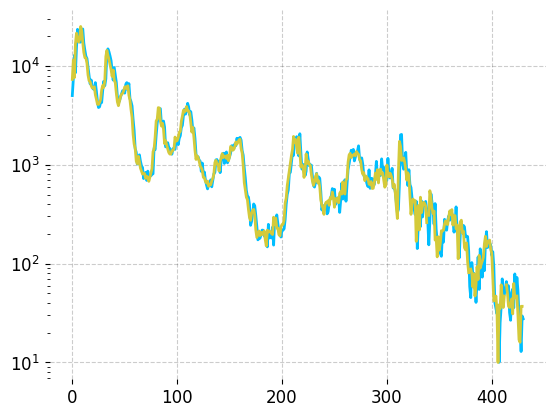

In [6]:
plt.plot(particles[:,0,2] * rho)
plt.plot(ys)
plt.yscale('log')

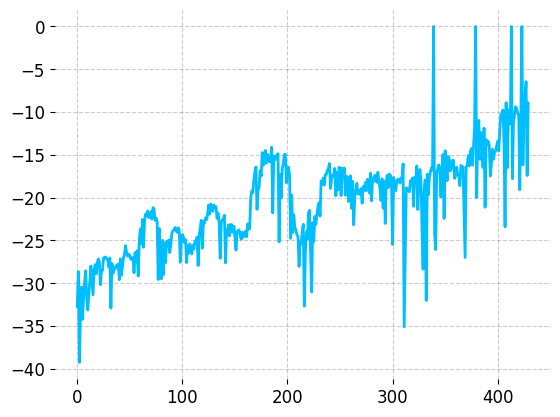

In [7]:
plt.plot(meas_particles.mean(-1))

In [6]:

def ppop_helper(t, inputs):
    particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key = inputs
    J = len(particlesF)
    
    if len(covars.shape) > 2:
        key, *keys = jax.random.split(key, num=J*covars.shape[1]+1)
        keys = np.array(keys).reshape(J, covars.shape[1], 2).astype(np.uint32)
    else:    
        key, *keys = jax.random.split(key, num=J+1)
        keys = np.array(keys)
        
    # Discount weights by alpha in logspace
    weightsP = alpha*weightsF

    # Get prediction particles 
    if covars is not None:
        particlesP, weightsC = rprocess_weight(particlesF, theta, keys, covars, 1/7, alpha)# if t>0 else particlesF
    else:
        particlesP, weightsC = rprocess_weight(particlesF, theta, keys, None, 1/7, alpha)

    # Correction for deulermultinom
    weightsP += weightsC - jax.lax.stop_gradient(weightsC)

    # This uses the DOP measurement density
    # i.e. particles evaluated at \phi: f_{Y_n|X_n}(y_n^*|X_{n,j}^{P,\phi};\theta)
    #measurements = dmeasure(ys[t], jax.lax.stop_gradient(particlesP), theta)
    measurements = dmeasure(ys[t], particlesP, theta)
    if len(measurements.shape) > 1:
        measurements = measurements.sum(axis=-1)
    
    # Using before-resampling conditional likelihood
    loglik += (jax.scipy.special.logsumexp(weightsP + measurements) 
               - jax.scipy.special.logsumexp(weightsP))
    
    # Obtain normalized measurement likelihoods for resampling
    norm_weights, loglik_phi_t = normalize_weights(jax.lax.stop_gradient(measurements))

    # Systematic resampling according to normalized measurement likelihoods
    counts, particlesF, norm_weightsF = resampler(counts, particlesP, norm_weights)
    
    # Correct for theta/phi and resample
    weightsF = (weightsP + measurements - jax.lax.stop_gradient(measurements))[counts]

    #jax.debug.print(loglik, loglik_t)
    return [particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key]

    
# test on linear gaussian toy model again
@partial(jit, static_argnums=2)
def ppop(theta, ys, J, covars=None, alpha=0.97, key=None):
    if key is None:
        key = jax.random.PRNGKey(onp.random.choice(int(1e18)))
    
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    weightsF = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=ppop_helper, 
                 init_val=[particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key])
    
    return -loglik

# test on linear gaussian toy model again
@partial(jit, static_argnums=2)
def ppop_mean(theta, ys, J, covars=None, alpha=0.97, key=None):
    if key is None:
        key = jax.random.PRNGKey(onp.random.choice(int(1e18)))
    
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    weightsF = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = 0
    
    particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=ppop_helper, 
                 init_val=[particlesF, theta, covars, loglik, weightsF, counts, ys, alpha, key])
    
    return -loglik/len(ys)



In [7]:

    
    
@partial(jax.jit, static_argnums=(6,7,8))
def mif(theta, ys, sigmas, sigmas_init, covars, key, M=10, 
        a=0.9, J=100):
    
    logliks = np.zeros(M+1)
    params = np.zeros((M+1, J, theta.shape[-1]))
    
    thetas = theta + sigmas_init*jax.random.normal(key=key, shape=(J, theta.shape[-1]))
    key, subkey = jax.random.split(key)
    params = params.at[0].set(thetas)
    
        
    def mif_helper(m, inputs):
        logliks, params, thetas, sigmas, covars, ys, a, key = inputs
        sigmas *= a
        
        thetas += sigmas*jax.random.normal(key=key, shape=thetas.shape)
        key, subkey = jax.random.split(key)
        loglik_ext, thetas = perfilter(thetas, ys, J, sigmas, 
                                       covars=covars, a=a, thresh=-1, key=key)
        key, subkey = jax.random.split(key)
        params = params.at[m+1].set(thetas)
        
        loglik = pfilter(thetas.mean(0), ys, J, 
                              covars=covars, thresh=-1, key=key)
        
        logliks = logliks.at[m+1].set(loglik)
        return logliks, params, thetas, sigmas, covars, ys, a, key
    
    
    key, subkey = jax.random.split(key)
    loglik = pfilter(thetas.mean(0), ys, J, 
                          covars=covars, thresh=-1, key=key)
    logliks = logliks.at[0].set(loglik)
    logliks, params, thetas, sigmas, covars, ys, a, key \
        = jax.lax.fori_loop(0, M, mif_helper, 
                            (logliks, params, thetas, sigmas, covars, ys, a, key))
    
    return logliks, params


@partial(jit, static_argnums=2)
def jgrad_ppop(theta_ests, ys, J, covars, alpha=0.97, key=None):
    return jax.grad(ppop_mean)(theta_ests, ys, J, covars=covars, alpha=alpha, key=key)

@partial(jit, static_argnums=2)
def jvg_ppop(theta_ests, ys, J, covars, alpha=0.97, key=None):
    return jax.value_and_grad(ppop_mean)(theta_ests, ys, J, covars=covars, alpha=alpha, key=key)


@partial(jax.jit, static_argnums=(4,7))
def gd_ppop(theta, ys, covars, key, M=10, 
        alpha=0.97, eta = 0.2, J=100):
    
    logliks = np.zeros(M+1)
    params = np.zeros((M+1, theta.shape[-1]))
    
    params = params.at[0].set(theta)
    
    def gd_helper(m, inputs):
        logliks, params, theta, covars, ys, alpha, eta, key = inputs

        grad = jgrad_ppop(theta, 
                np.where(np.isnan(ys), 0, ys), 
          J, covars=covars, key=key, alpha=alpha)
        key, subkey = jax.random.split(key)
        theta -= eta*np.where(np.isnan(grad), 0, grad)
        
        params = params.at[m+1].set(theta)
        
        loglik = pfilter(theta, ys, J, 
                              covars=covars, thresh=-1, key=key)
        logliks = logliks.at[m+1].set(loglik)
        
        return logliks, params, theta, covars, ys, alpha, eta, key
    
    key, subkey = jax.random.split(key)
    loglik = pfilter(theta, ys, J, 
                          covars=covars, thresh=-1, key=key)
    logliks = logliks.at[0].set(loglik)
    logliks, params, theta, covars, ys, alpha, eta, key \
        = jax.lax.fori_loop(0, M, gd_helper, 
                            (logliks, params, theta, covars, ys, alpha, eta, key))
    
    return logliks, params


               
                       

In [24]:
%timeit jgrad_ppop(theta_ests, ys, J, covars, alpha=0.97, key=None)

8.81 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:

sigmas = (np.abs(theta)/60)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) 


In [11]:
jgrad_ppop(theta_ests, ys, J, covars, alpha=0.97, key=None)


KeyboardInterrupt



In [ ]:
grads = onp.array([jgrad_ppop(theta, ys, J, covars, alpha=0.97, key=jax.random.PRNGKey(i)) 
                   for i in tqdm(range(30))])
grads0 = onp.array([jgrad_ppop(theta, ys, J, covars, alpha=0, key=jax.random.PRNGKey(i)) 
                   for i in tqdm(range(30))])
grads1 = onp.array([jgrad_ppop(theta, ys, J, covars, alpha=1, key=jax.random.PRNGKey(i)) 
                   for i in tqdm(range(30))])

 10%|█         | 3/30 [00:38<04:56, 10.99s/it]

In [ ]:
i = -1
plt.hist(grads1[:,i], alpha=1, label='PPOP-1')
plt.hist(grads[:,i], alpha=1, label='PPOP-0.97')
plt.hist(grads0[:,i], alpha=1, label='PPOP-0')
plt.axvline(0, linestyle='--', color='black')
plt.legend()

In [ ]:
ppop_grads = [[jgrad_ppop(theta, 
                   ys, J, covars, alpha, jax.random.PRNGKey(i))
             for i in tqdm(range(100))] 
             for alpha in [0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1]]
np.save('../outs/grads/ppop_grads.npy', ppop_grads)

In [105]:
len([0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1])

12

In [102]:
i=4
np.array([(np.array(ppop_grads[i]).mean(0)**2).sum() for i in range(len(ppop_grads))])

Array([11.4839   , 11.476764 , 11.512846 , 11.556937 , 11.625115 ,
       11.688509 , 11.7429085, 11.835243 , 12.018435 , 12.140499 ,
       12.180727 , 12.675275 ], dtype=float32)

In [104]:
np.array(ppop_grads).shape

(12, 100, 13)

In [121]:
alphas_orig

[0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1]

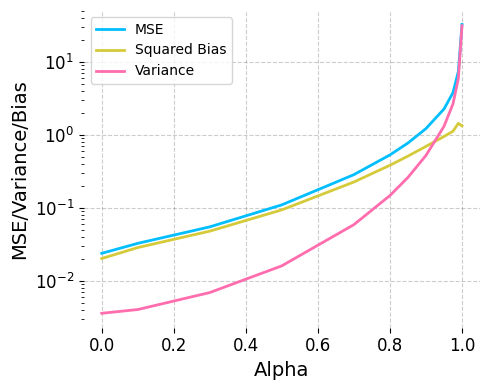

In [41]:
j = -1
alphas_orig = [0,0.1,0.3,0.5,0.7,0.8,0.85,0.9,0.95,0.975,0.99,1]
variance_alphas = np.array([np.var(np.array(ppop_grads)[i,:,j],axis=0)
                            for i in range(len(ppop_grads))])
mse_alphas = np.array([np.mean(np.array(ppop_grads)[i,:,j]**2) for i in range(len(ppop_grads))])
bias_alphas = np.array([(np.array(ppop_grads)[i,:,j].mean()**2) for i in range(len(ppop_grads))])
plt.figure(figsize=(5,4))
plt.plot(alphas_orig,mse_alphas,
         label='MSE')
plt.plot(alphas_orig,bias_alphas,
         label='Squared Bias')
plt.plot(alphas_orig,variance_alphas,
         label='Variance')
plt.legend()
#plt.title('Bias-Variance Tradeoff for Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE/Variance/Bias')
plt.yscale('log')
plt.tight_layout()
#plt.text(0.05, 0.16, 'B', fontsize=36)
plt.savefig('../imgs/haiti/biasvar.png', dpi=300)
plt.show()

In [61]:
grads[:,6]

array([-0.22583322,  0.4170357 , -1.2902255 , -0.07882103,  0.7515115 ,
        0.57012486,  0.22152618,  0.49681076,  0.07289892, -0.02938023],
      dtype=float32)

In [ ]:
transform_thetas(rho, tau1, tau2, bs, nu, sig_sq1, sig_sq2, beta_t)

In [45]:
bbox = get_rand_theta(1).squeeze()
orig_loglik = pfilter(bbox, ys, J, covars, thresh=-1)
mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                          sigmas_init = 1e-20, covars=covars, key=key,
                          M=40, J=J, a=0.95) 
theta_ests = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
gd_logliks_ppop, gd_ests_ppop = gd_ppop(theta_ests, ys, covars, key, M=60, alpha=0.97, eta=0.01, J=J) #0.97 


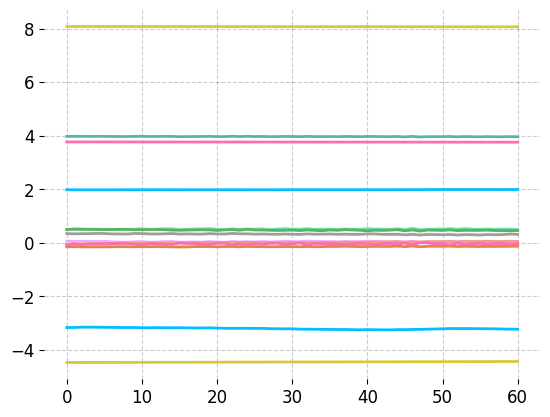

In [46]:
plt.plot(gd_ests_ppop)
plt.show()

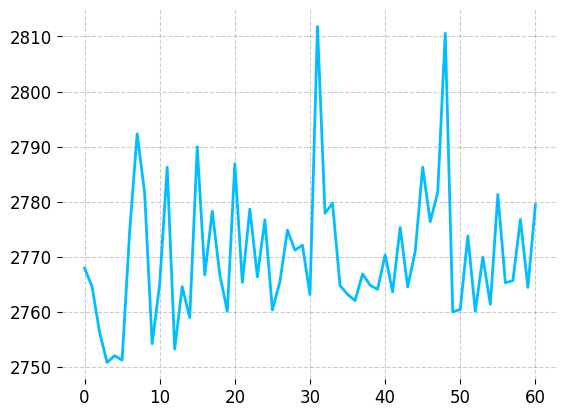

In [47]:
#plt.plot(mif_logliks_warm[6:])
plt.plot(gd_logliks_ppop)

In [459]:
jax.grad(ppop_mean)(theta, ys, J, covars=covars, alpha=0.97, key=jax.random.PRNGKey(0))

Array([ 0.0164067 , -0.00920002, -0.00754104, -1.2196813 , -1.073101  ,
       -0.6266865 , -1.5919315 , -1.7558331 , -0.50003606, -0.10852237,
        2.9639328 ,  2.1135209 ,  5.5225296 ], dtype=float32)

In [ ]:
n_trials = 30
J = 10000


original_logliks = []
original_theta_ests = []

mif_logliks_trials = []
mif_params_trials = []

mif_logliks_warm_trials = []
mif_params_warm_trials = []

gd_logliks_trials = []
gd_ests_trials = []

gd_logliks_pf_trials = []
gd_ests_pf_trials = []

gd_logliks_ppop_trials = []
gd_ests_ppop_trials = []


for trial in tqdm(range(n_trials)):
    key = jax.random.PRNGKey(trial)
    bbox = get_rand_theta(1).squeeze()
    print('bbox')
    orig_loglik = pfilter(bbox, ys, J, covars, thresh=-1)
    print('orig_loglik: '+str(orig_loglik))
    mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                              sigmas_init = 1e-20, covars=covars, key=key,
                              M=40, J=J, a=0.95) 
    print('mif_loglik_warm: '+str(mif_logliks_warm.min()))
    theta_ests = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
    
    gd_logliks_ppop, gd_ests_ppop = gd_ppop(theta_ests, ys, covars, key,
                                  M=60, alpha=0.8, eta=0.01, J=J) #0.97 
    print('ppop_loglik_0.8: '+str(gd_logliks_ppop.min())+', '+str(gd_logliks_ppop[-1]))
    
    gd_logliks_pf, gd_ests_pf = gd_ppop(theta_ests, ys, covars, key,
                                  M=60, alpha=0, eta=0.01, J=J) 
    print('ppop_loglik_0: '+str(gd_logliks_pf.min())+', '+str(gd_logliks_pf[-1]))
    
    gd_logliks, gd_ests = gd_ppop(theta_ests, ys, covars, key,
                                  M=60, alpha=1, eta=0.01, J=J)
    print('ppop_loglik_1: '+str(gd_logliks.min())+', '+str(gd_logliks[-1]))

    mif_logliks, mif_params = mif(bbox, ys, sigmas=0.02, 
                              sigmas_init = 1e-20, covars=covars, key=key,
                              M=100, J=J, a=0.95) 
    print('mif_loglik: '+str(mif_logliks.min()))
    
    
    
    original_logliks.append(orig_loglik)
    original_theta_ests.append(theta_ests)
    
    
    outf = open('../outs/log/trials'+str(trial)+'.txt', 'w')
    outf.write(str(trial) + ' orig ' + str(orig_loglik) + ' gd ' + str(gd_logliks_ppop[-1]) + ' , ' + str(min(gd_logliks_ppop)) + ' mif ' + str(mif_logliks[-1]) + ' , ' + str(min(mif_logliks)))
    outf.close()
    print('orig', orig_loglik, 'gd', gd_logliks_ppop[-1], 'if2', mif_logliks[-1])
    
    mif_logliks_trials.append(mif_logliks)
    mif_params_trials.append(mif_params)
    
    mif_logliks_warm_trials.append(mif_logliks_warm)
    mif_params_warm_trials.append(mif_params_warm)
    
    gd_logliks_trials.append(gd_logliks)
    gd_ests_trials.append(gd_ests)
    
    gd_logliks_pf_trials.append(gd_logliks_pf)
    gd_ests_pf_trials.append(gd_ests_pf)
    
    gd_logliks_ppop_trials.append(gd_logliks_ppop)
    gd_ests_ppop_trials.append(gd_ests_ppop)
    
    
    suff = '-08ppop-constantlr-0point01'
    file = '-0'
    np.save('../outs/ppop/mif_logliks_trials'+suff+file+'.npy', np.array(mif_logliks_trials))
    np.save('../outs/ppop/mif_logliks_warm_trials'+suff+file+'.npy', np.array(mif_logliks_warm_trials))
    np.save('../outs/ppop/gd_logliks_trials'+suff+file+'.npy', np.array(gd_logliks_trials))
    np.save('../outs/ppop/gd_logliks_pf_trials'+suff+file+'.npy', np.array(gd_logliks_pf_trials))
    np.save('../outs/ppop/gd_logliks_ppop_trials'+suff+file+'.npy', np.array(gd_logliks_ppop_trials))

  0%|          | 0/30 [00:00<?, ?it/s]

bbox
orig_loglik: 2936.2314
mif_loglik_warm: 2749.2773
ppop_loglik_0.8: 2733.314, 2733.6006
ppop_loglik_0: 2733.9824, 2735.1638
ppop_loglik_1: 2739.0435, 2804.4565
mif_loglik: 2742.4978


  3%|▎         | 1/30 [1:21:30<39:23:52, 4890.76s/it]

orig 2936.2314 gd 2733.6006 if2 2810.18
bbox
orig_loglik: 3076.1392
mif_loglik_warm: 2810.23
ppop_loglik_0.8: 2750.5454, 2763.9106
ppop_loglik_0: 2766.1746, 2775.765
ppop_loglik_1: 2762.2932, 2778.4338


  7%|▋         | 2/30 [2:41:21<37:34:53, 4831.90s/it]

mif_loglik: 2770.1895
orig 3076.1392 gd 2763.9106 if2 2865.1113
bbox
orig_loglik: 3027.1265
mif_loglik_warm: 2774.6365
ppop_loglik_0.8: 2752.8542, 2761.8313
ppop_loglik_0.8: 2756.0554, 2758.0942
ppop_loglik_0: 2757.4834, 2759.3691
ppop_loglik_0: 2756.8384, 2757.5046
mif_loglik_warm: 2773.199
ppop_loglik_1: 2760.097, 2770.9785
mif_loglik_warm: 2795.4543


In [ ]:
np.array(mif_logliks_trials).shape